In [1]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
from utilities.custom_indicators import get_n_columns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [2]:
pair = "BTC/USDT"
tf = "1h"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../database/"
)

In [3]:
def monkey_strategy(df, open_p, close_p, type=["long","short"], fees=0.0007):
    df["open_trade"] = 0
    df["close_trade"] = 0
    # LONG
    if "long" in type:
        df["open_trade"] = np.random.binomial(
            n = 1, p = open_p, size=[len(df)]
        )
    # SHORT
    if "short" in type:
        df.loc[df["open_trade"]==0, "open_trade"] = -np.random.binomial(
            n = 1, p=open_p, size=[len(df.loc[df["open_trade"]==0])]
        )
    # CLOSE TRADES
    df.loc[df["open_trade"]==0, "close_trade"] = np.random.binomial(
        n = 1, p=close_p, size=[len(df.loc[df["open_trade"]==0])]
    )

    dt = pd.concat([df[df["open_trade"] != 0], df[df["close_trade"] != 0]])
    dt.sort_index(inplace=True)
    rows_to_drop1 = dt[(abs(dt['open_trade']) == abs(dt['open_trade'].shift(1))) & (dt['open_trade'] != 0)].index
    dt.drop(rows_to_drop1, inplace=True)
    rows_to_drop2 = dt[(dt['close_trade'] == dt['close_trade'].shift(1)) & (dt['close_trade'] != 0)].index
    dt.drop(rows_to_drop2, inplace=True)

    current_position = None
    trades = []
    wallet = 1000

    for index, row in dt.iterrows():
        if current_position:
            if row["close_trade"] != 0:
                close_price = row['close']
                if current_position['side'] == "LONG":
                    trade_result = ((close_price - current_position['price']) / current_position['price'])
                elif current_position['side'] == "SHORT":
                    trade_result = ((current_position['price'] - close_price) / current_position['price'])
                wallet += wallet * trade_result
                fee = wallet * fees
                wallet -= fee
                trades.append({
                    "open_date": current_position['date'],
                    "close_date": index,
                    "position": current_position['side'],
                    "open_reason": current_position['reason'],
                    "close_reason": "Market",
                    "open_price": current_position['price'],
                    "close_price": close_price,
                    "open_fee": current_position['fee'],
                    "close_fee": fee,
                    "open_trade_size":current_position['size'],
                    "close_trade_size": wallet,
                    "wallet": wallet
                })
                current_position = None
        else:
            if row["open_trade"] != 0:
                open_price = row['close']
                fee = wallet * fees
                wallet -= fee
                pos_size = wallet
                current_position = {
                    "size": pos_size,
                    "date": index,
                    "price": open_price,
                    "fee":fee,
                    "reason": "Market",
                    "side": ("LONG" if row["open_trade"]==1 else "SHORT"),
                }

    return trades

Period: [2017-08-17 18:00:00] -> [2022-12-04 03:00:00]
Initial wallet: 999.3 $

--- General Information ---
Final wallet: 7796.16 $
Performance vs US dollar: 680.16 %
Worst Drawdown : -32.71%
Buy and hold performance: 298.4 %
Performance vs buy and hold: 95.83 %
Total trades on the period: 359
Global Win rate: 50.97 %
Average Profit: 0.68 %
Total fees paid 2373.9$

Best trades: +25.87 % the 2018-01-01 14:00:00 -> 2018-01-05 17:00:00
Worst trades: -24.48 % the 2017-11-08 08:00:00 -> 2017-11-12 06:00:00


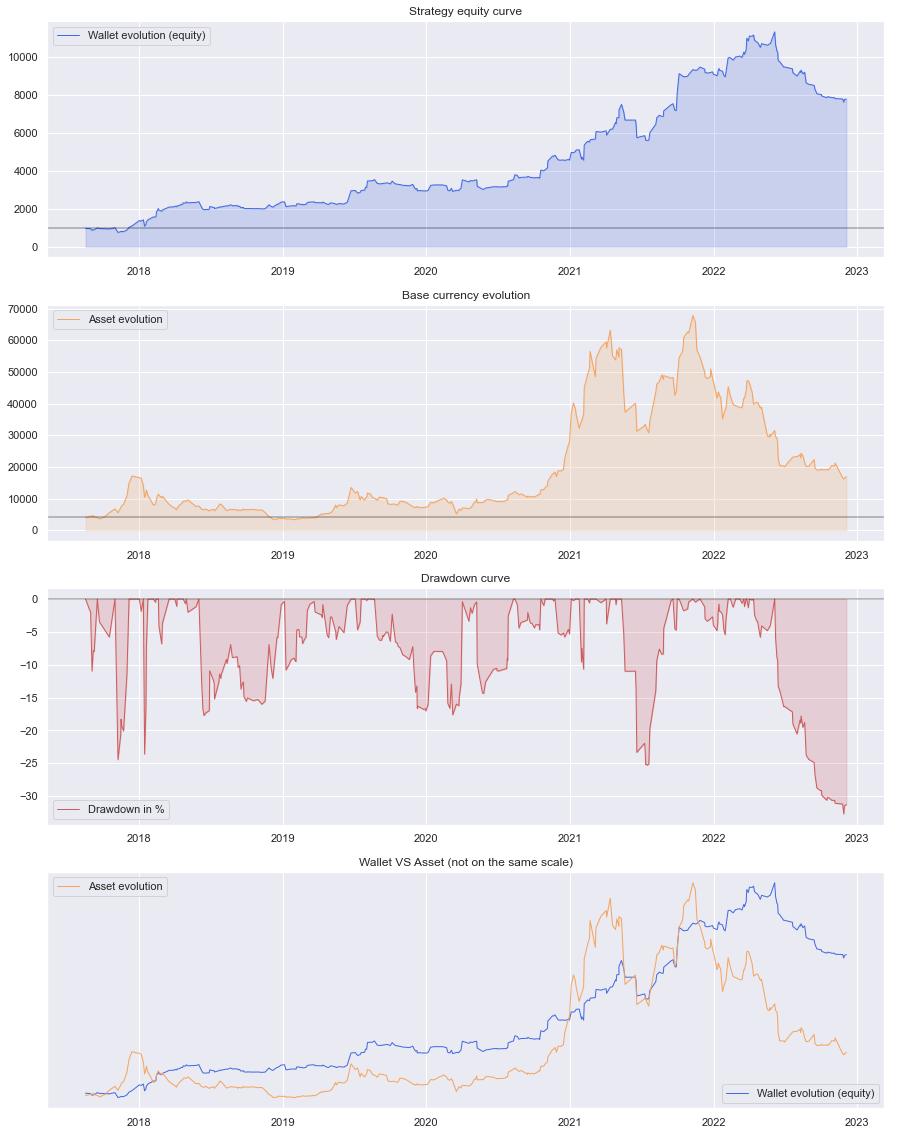

In [17]:
def basic_single_asset_backtest(trades):
    df_trades = trades.copy()
    
    
    df_trades['trade_result'] = df_trades["close_trade_size"] - df_trades["open_trade_size"] - df_trades["open_fee"]
    df_trades['trade_result_pct'] = df_trades['trade_result']/df_trades["open_trade_size"]
    df_trades['trade_result_pct_wallet'] = df_trades['trade_result']/(df_trades["wallet"]+df_trades["trade_result"])
    
    df_trades['wallet_ath'] = df_trades['wallet'].cummax()
    df_trades['drawdown'] = df_trades['wallet_ath'] - df_trades['wallet']
    df_trades['drawdown_pct'] = df_trades['drawdown'] / df_trades['wallet_ath']
    
    good_trades = df_trades.loc[df_trades['trade_result'] > 0]
    
    initial_wallet = df_trades.iloc[0]["open_trade_size"]
    total_trades = len(df_trades)
    total_good_trades = len(good_trades)
    avg_profit = df_trades['trade_result_pct'].mean()   
    global_win_rate = total_good_trades / total_trades
    max_trades_drawdown = df_trades['drawdown_pct'].max()
    final_wallet = df_trades.iloc[-1]["close_trade_size"]
    buy_and_hold_pct = (df_trades.iloc[-1]["close_price"] -  df_trades.iloc[0]["open_price"]) /  df_trades.iloc[0]["open_price"]
    buy_and_hold_wallet = initial_wallet + initial_wallet * buy_and_hold_pct
    vs_hold_pct = (final_wallet - buy_and_hold_wallet)/buy_and_hold_wallet
    vs_usd_pct = (final_wallet - initial_wallet)/initial_wallet
    total_fees = df_trades['open_fee'].sum() + df_trades['close_fee'].sum()
    
    best_trade = df_trades['trade_result_pct'].max()
    best_trade_date1 =  str(df_trades.loc[df_trades['trade_result_pct'] == best_trade].iloc[0]['open_date'])
    best_trade_date2 =  str(df_trades.loc[df_trades['trade_result_pct'] == best_trade].iloc[0]['close_date'])
    worst_trade = df_trades['trade_result_pct'].min()
    worst_trade_date1 =  str(df_trades.loc[df_trades['trade_result_pct'] == worst_trade].iloc[0]['open_date'])
    worst_trade_date2 =  str(df_trades.loc[df_trades['trade_result_pct'] == worst_trade].iloc[0]['close_date'])
    
    print("Period: [{}] -> [{}]".format(df_trades.iloc[0]['open_date'], df_trades.iloc[-1]['close_date']))
    print("Initial wallet: {} $".format(round(initial_wallet,2)))
    
    print("\n--- General Information ---")
    print("Final wallet: {} $".format(round(final_wallet,2)))
    print("Performance vs US dollar: {} %".format(round(vs_usd_pct*100,2)))
    print("Worst Drawdown : -{}%".format(round(max_trades_drawdown*100, 2)))
    print("Buy and hold performance: {} %".format(round(buy_and_hold_pct*100,2)))
    print("Performance vs buy and hold: {} %".format(round(vs_hold_pct*100,2)))
    print("Total trades on the period: {}".format(total_trades))
    print("Global Win rate: {} %".format(round(global_win_rate*100, 2)))
    print("Average Profit: {} %".format(round(avg_profit*100, 2)))
    print("Total fees paid {}$".format(round(total_fees, 2)))
    
    print("\nBest trades: +{} % the {} -> {}".format(round(best_trade*100, 2), best_trade_date1, best_trade_date2))
    print("Worst trades: {} % the {} -> {}".format(round(worst_trade*100, 2), worst_trade_date1, worst_trade_date2))

    return df_trades

def plot_wallet_vs_asset(df_trades, log=False):
    days = df_trades.copy()
    # print("-- Plotting equity vs asset and drawdown --")
    fig, ax_left = plt.subplots(figsize=(15, 20), nrows=4, ncols=1)

    ax_left[0].title.set_text("Strategy equity curve")
    ax_left[0].plot(days['wallet'], color='royalblue', lw=1)
    if log:
        ax_left[0].set_yscale('log')
    ax_left[0].fill_between(days['wallet'].index, days['wallet'], alpha=0.2, color='royalblue')
    ax_left[0].axhline(y=days.iloc[0]['wallet'], color='black', alpha=0.3)
    ax_left[0].legend(['Wallet evolution (equity)'], loc ="upper left")

    ax_left[1].title.set_text("Base currency evolution")
    ax_left[1].plot(days['close_price'], color='sandybrown', lw=1)
    if log:
        ax_left[1].set_yscale('log')
    ax_left[1].fill_between(days['close_price'].index, days['close_price'], alpha=0.2, color='sandybrown')
    ax_left[1].axhline(y=days.iloc[0]['close_price'], color='black', alpha=0.3)
    ax_left[1].legend(['Asset evolution'], loc ="upper left")

    ax_left[2].title.set_text("Drawdown curve")
    ax_left[2].plot(-days['drawdown_pct']*100, color='indianred', lw=1)
    ax_left[2].fill_between(days['drawdown_pct'].index, -days['drawdown_pct']*100, alpha=0.2, color='indianred')
    ax_left[2].axhline(y=0, color='black', alpha=0.3)
    ax_left[2].legend(['Drawdown in %'], loc ="lower left")

    ax_right = ax_left[3].twinx()
    if log:
        ax_left[3].set_yscale('log')
        ax_right.set_yscale('log')

    ax_left[3].title.set_text("Wallet VS Asset (not on the same scale)")
    ax_left[3].set_yticks([])
    ax_right.set_yticks([])
    ax_left[3].plot(days['wallet'], color='royalblue', lw=1)
    ax_right.plot(days['close_price'], color='sandybrown', lw=1)
    ax_left[3].legend(['Wallet evolution (equity)'], loc ="lower right")
    ax_right.legend(['Asset evolution'], loc ="upper left")

    plt.show()

trades = monkey_strategy(
    df=df, 
    open_p=1/100,
    close_p=1/24,
    type=["long"],
    fees=0.0007
)
df_trades = pd.DataFrame(trades)
df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
df_trades = df_trades.set_index(df_trades['open_date'])  
df_trades = basic_single_asset_backtest(df_trades)
plot_wallet_vs_asset(df_trades)

In [49]:
simulation = [
    monkey_strategy(
        df=df, 
        open_p=1/24,
        close_p=1/24,
        type=["long", "short"],
        fees=0.0007
    ) for x in range(1000)
]

In [50]:
wallets = []
win_rates = []
avg_profits = []
total_trades = []
max_drawdowns = []
winners = 0

def get_metrics(trades):
    df_trades = pd.DataFrame(trades)
    
    df_trades['wallet_ath'] = df_trades['wallet'].cummax()
    df_trades['drawdown'] = df_trades['wallet_ath'] - df_trades['wallet']
    df_trades['drawdown_pct'] = df_trades['drawdown'] / df_trades['wallet_ath']
    max_drawdown = -df_trades['drawdown_pct'].max() * 100
    
    
    df_trades['trade_result'] = df_trades["close_trade_size"] - df_trades["open_trade_size"] - df_trades["open_fee"] - df_trades["close_fee"]
    df_trades['trade_result_pct'] = df_trades['trade_result']/df_trades["open_trade_size"]
    df_trades['trade_result_pct_wallet'] = df_trades['trade_result']/(df_trades["wallet"]+df_trades["trade_result"])
    good_trades = df_trades.loc[df_trades['trade_result_pct'] > 0]
    win_rate = len(good_trades) / len(df_trades)
    avg_profit = df_trades['trade_result_pct'].mean()
    
    return {
        "wallet": trades[-1]["wallet"],
        "win_rate": win_rate,
        "avg_profit": avg_profit,
        "total_trades": len(df_trades),
        "max_drawdown": max_drawdown
    }

for i in range(len(simulation) - 1):
    trades = simulation[i]
    metrics = get_metrics(trades)
    wallets.append(metrics["wallet"])
    win_rates.append(metrics["win_rate"])
    avg_profits.append(metrics["avg_profit"])
    total_trades.append(metrics["total_trades"])
    max_drawdowns.append(metrics["max_drawdown"])
    if metrics["wallet"] > 1000:
        winners += 1

print(f"Mean final wallet: {round(sum(wallets) / len(wallets), 2)}$")
print(f"Mean Win rate: {round(100 * sum(win_rates) / len(win_rates), 2)}%")
print(f"Mean average profit: {round(100 * sum(avg_profits) / len(avg_profits), 2)}%")
print(f"Mean max drawdown: {round(sum(max_drawdowns) / len(max_drawdowns), 2)}")
print(f"Mean total_trades: {round(sum(total_trades) / len(total_trades), 2)}")
print(f"{winners} monkeys won, {round(winners*100/len(simulation),2)}% of the population")

Mean final wallet: 178.19$
Mean Win rate: 44.03%
Mean average profit: -0.21%
Mean max drawdown: -94.4
Mean total_trades: 1207.09
27 monkeys won, 2.7% of the population


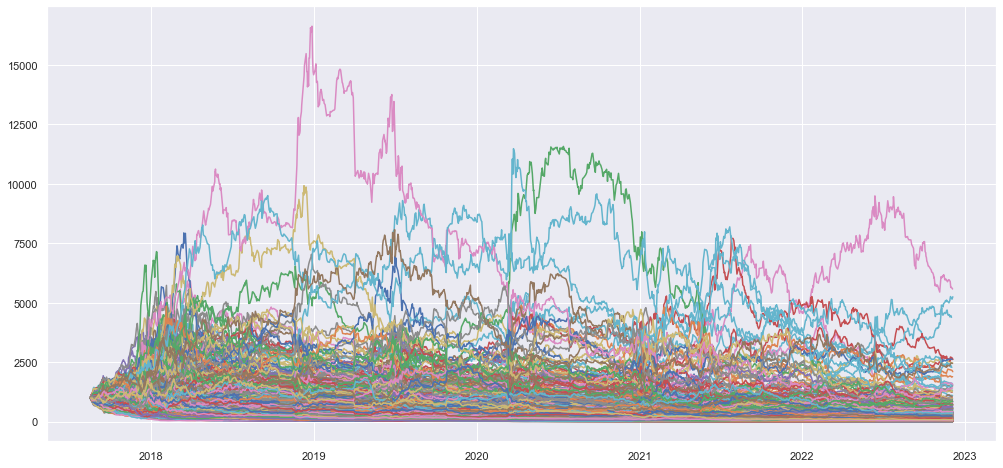

In [51]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(17,8)})
fig, ax = plt.subplots()
# ax.set_yscale('log')
for i in range(len(simulation) - 1):
    trades = simulation[i]
    wallet_evolution = [t["wallet"] for t in trades]
    time_list = [t["close_date"] for t in trades]
    
    ax.plot(time_list, wallet_evolution)